In [121]:
# Required imports
import os
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [122]:
cpiDf = pd.read_csv(
    Path("resources/foodPrice.csv")
)

cpiDf.head()

,Cereals-and-bakery-products,"Meats,-poultry,-fish,-and-eggs",Dairy-and-related-products,Fruits-and-vegetables,Other-food-at-home,Date
0,79.7,90.4,87.3,76.5,83.0,1980-01-01
1,80.6,89.7,87.8,76.0,84.3,1980-02-01
2,81.2,90.3,88.1,77.4,85.5,1980-03-01
3,82.4,89.3,88.9,80.2,86.4,1980-04-01
4,83.2,88.0,90.5,82.1,87.3,1980-05-01


In [123]:
cpiDf.rename({'Dairy-and-related-products': 'Dairy-products'},axis='columns',inplace = True)
cats = cpiDf.columns.to_list()
cats = [i.replace('-',' ') for i in cats if i != 'Date']

In [129]:
spendDf = pd.read_csv(Path(f"resources/spending_2005-2022.csv"),index_col = 'Item')
spendDf = spendDf.loc[cats]
yearAndCat = []
for cat,year in zip(spendDf.index,spendDf['Year']):
    ind = f'{cat} ({int(year)})'
    yearAndCat.append(ind)
spendDf.index = yearAndCat
spendDf.drop(columns='Year',inplace=True)
spendDf = spendDf.T
spendDf = spendDf.reset_index().rename({'index':'City'},axis='columns')

spendDf = spendDf.dropna(axis='index').reset_index(drop=True)
spendDf.head()

,City,Cereals and bakery products (2005),Cereals and bakery products (2006),Cereals and bakery products (2007),Cereals and bakery products (2008),Cereals and bakery products (2009),Cereals and bakery products (2010),Cereals and bakery products (2011),Cereals and bakery products (2012),Cereals and bakery products (2013),...,Other food at home (2013),Other food at home (2014),Other food at home (2015),Other food at home (2016),Other food at home (2017),Other food at home (2018),Other food at home (2019),Other food at home (2020),Other food at home (2021),Other food at home (2022)
0,Chicago,473.0,491.0,537.0,561.0,584.0,615.0,602.0,596.0,664.0,...,1598.0,1652.0,1578.0,1562.0,1595.0,1666.0,1777.0,2119.0,2174.0,2035.0
1,Detroit,545.0,527.0,579.0,628.0,540.0,546.0,573.0,583.0,618.0,...,1748.0,1691.0,1400.0,1422.0,1463.0,1626.0,1636.0,1762.0,1887.0,2051.0
2,Minneapolis-St.Paul,493.0,470.0,517.0,536.0,518.0,582.0,632.0,639.0,582.0,...,1608.0,1764.0,1792.0,1682.0,1743.0,1833.0,2126.0,2152.0,2001.0,2317.0
3,New York,568.0,533.0,528.0,535.0,558.0,565.0,597.0,601.0,590.0,...,1236.0,1283.0,1228.0,1191.0,1364.0,1500.0,1635.0,1807.0,1994.0,2163.0
4,Philadelphia,522.0,454.0,408.0,467.0,526.0,523.0,529.0,605.0,656.0,...,1433.0,1365.0,1305.0,1444.0,1637.0,1740.0,1701.0,1968.0,2230.0,2252.0


In [130]:
## maybe calculate average changes
fullAvg = []
for cat in cats:
    temp = spendDf[[i for i in spendDf.columns if cat in i]]
    catAvgChange = np.mean(np.diff(temp)/np.array(temp)[:,:17],axis=1)
    spendDf[f'{cat} Average Change'] = catAvgChange*100
    fullAvg.append(catAvgChange)
spendDf['Average Change'] = np.mean(fullAvg,axis=0)*100

:NdOverlay   [City]
   :Scatter   [Meats, poultry, fish, and eggs (2022)]   (Fruits and vegetables (2022),Average Change)
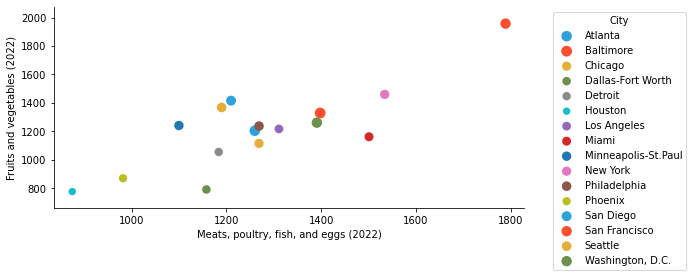

In [131]:
spendDf.hvplot.scatter(
    x="Meats, poultry, fish, and eggs (2022)",
    y="Fruits and vegetables (2022)",
    s='Average Change',
    scale=50,
    by="City")

In [132]:
spendDfDummy = pd.get_dummies(spendDf)
# StandardScaler().fit_transform(spendDfDummy)
spendDfDummy.head()
# spendDfDummy = spendDf.drop(columns='City')
# spendDfDummy

,Cereals and bakery products (2005),Cereals and bakery products (2006),Cereals and bakery products (2007),Cereals and bakery products (2008),Cereals and bakery products (2009),Cereals and bakery products (2010),Cereals and bakery products (2011),Cereals and bakery products (2012),Cereals and bakery products (2013),Cereals and bakery products (2014),...,City_Los Angeles,City_Miami,City_Minneapolis-St.Paul,City_New York,City_Philadelphia,City_Phoenix,City_San Diego,City_San Francisco,City_Seattle,"City_Washington, D.C."
0,473.0,491.0,537.0,561.0,584.0,615.0,602.0,596.0,664.0,661.0,...,0,0,0,0,0,0,0,0,0,0
1,545.0,527.0,579.0,628.0,540.0,546.0,573.0,583.0,618.0,544.0,...,0,0,0,0,0,0,0,0,0,0
2,493.0,470.0,517.0,536.0,518.0,582.0,632.0,639.0,582.0,525.0,...,0,0,1,0,0,0,0,0,0,0
3,568.0,533.0,528.0,535.0,558.0,565.0,597.0,601.0,590.0,609.0,...,0,0,0,1,0,0,0,0,0,0
4,522.0,454.0,408.0,467.0,526.0,523.0,529.0,605.0,656.0,613.0,...,0,0,0,0,1,0,0,0,0,0


In [133]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(spendDfDummy)
clusters = model.predict(spendDfDummy)
print(clusters)

[0 1 0 2 2 0 2 2 2 1 1 2 0 0 0 1]


:NdOverlay   [Cluster]
   :Scatter   [Meats, poultry, fish, and eggs (2022)]   (Fruits and vegetables (2022),City)
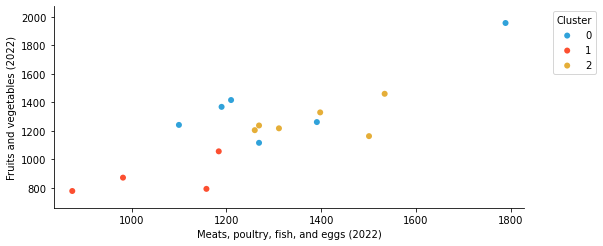

In [134]:
clusterDf = spendDf.copy()
clusterDf['Cluster'] = clusters
clusterDf.hvplot.scatter(
    x="Meats, poultry, fish, and eggs (2022)",
    y="Fruits and vegetables (2022)",
    by="Cluster",
    hover_cols=['City'])

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
spendPca = pca.fit_transform(spendDfDummy)
pca.explained_variance_ratio_

array([0.4732204 , 0.21885699, 0.10835317])

In [136]:
# Create the PCA DataFrame
spendPcaDf = pd.DataFrame(
    spendPca,
    columns=["PCA1", "PCA2",'PCA3']
)

# Review the PCA DataFrame
spendPcaDf.head()

,PCA1,PCA2,PCA3
0,322.766633,253.550649,-388.691435
1,-302.439338,221.621004,-391.621210
2,413.076418,761.781164,20.110776
3,369.436832,-1007.285501,-353.576808
4,148.979148,-138.094588,386.433540


In [137]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of teh KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(spendPcaDf)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

c:\Users\shane\anaconda3\envs\bootcamp\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,k,inertia
0,1,2.572690e+07
1,2,1.550918e+07
2,3,1.080212e+07
3,4,8.462482e+06
4,5,6.301915e+06


:Curve   [k]   (inertia)
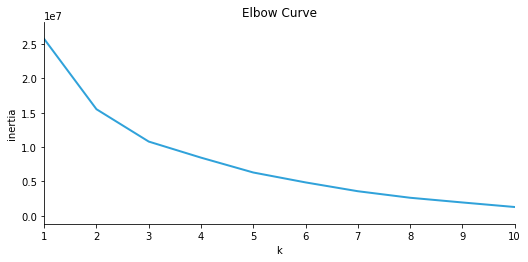

In [138]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

In [139]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(spendPcaDf)

# Make predictions
k_3 = model.predict(spendPcaDf)

# Create a copy of the PCA DataFrame
spendPcaDf_pred = spendPcaDf.copy()

# Add a class column with the labels
spendPcaDf_pred["customer_segments"] = k_3

# spendPcaDf_pred['City'] = spendDf['City']
spendPcaDf_pred = pd.merge(spendPcaDf_pred,spendDf,left_index=True,right_index=True)

# fullAvg = []
# for cat in cats:
#     temp = spendPcaDf_pred[[i for i in spendPcaDf_pred.columns if cat in i]]
#     catAvgChange = np.mean(np.diff(temp)/np.array(temp)[:,:17],axis=1)
#     spendPcaDf_pred[f'{cat} Average Change'] = catAvgChange
#     fullAvg.append(catAvgChange)
# spendPcaDf_pred['Average Change'] = np.mean(fullAvg,axis=0)*100


:NdOverlay   [customer_segments]
   :Scatter   [PCA1]   (PCA2,Average Change,City)
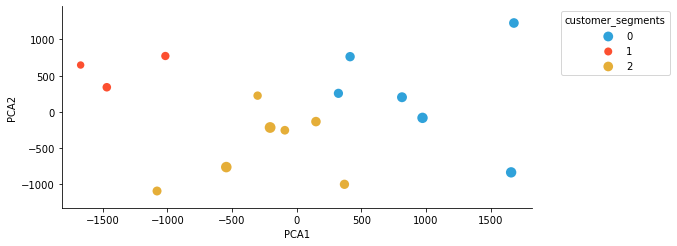

In [140]:
spendPcaDf_pred.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    s = 'Average Change',
    scale = 50,
    by="customer_segments",
    hover_cols=['City']

)


In [141]:
import plotly.express as px

pcaPriceDfPredictionsPlot = spendPcaDf_pred.reset_index()
# fig = px.scatter_3d(spendPcaDf_pred, x="Cereals and bakery products Average Change", y="Fruits and vegetables Average Change", z="Meats, poultry, fish, and eggs Average Change",size = 'Average Change',
#                     color='customer_segments',color_continuous_scale= px.colors.sequential.Rainbow,hover_name='City')
fig = px.scatter_3d(spendPcaDf_pred, x="PCA1", y="PCA2", z="PCA3",size = 'Average Change',
                    color='customer_segments',color_continuous_scale= px.colors.sequential.Rainbow,hover_name='City')

fig.show()